# Linear Regression in Tensorflow Probability

- toc: true 
- badges: true
- comments: true
- author: Nipun Batra
- categories: [ML]

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import tensorflow_probability as tfp
import pandas as pd
tfd = tfp.distributions
tfl = tfp.layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import Callback
sns.reset_defaults()
sns.set_context(context='talk',font_scale=1)
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
np.random.seed(42)
x = np.linspace(-0.5, 1, 100)
y = 5*x + 4 + 2*np.multiply(x, np.random.randn(100))

Text(0, 0.5, 'y')

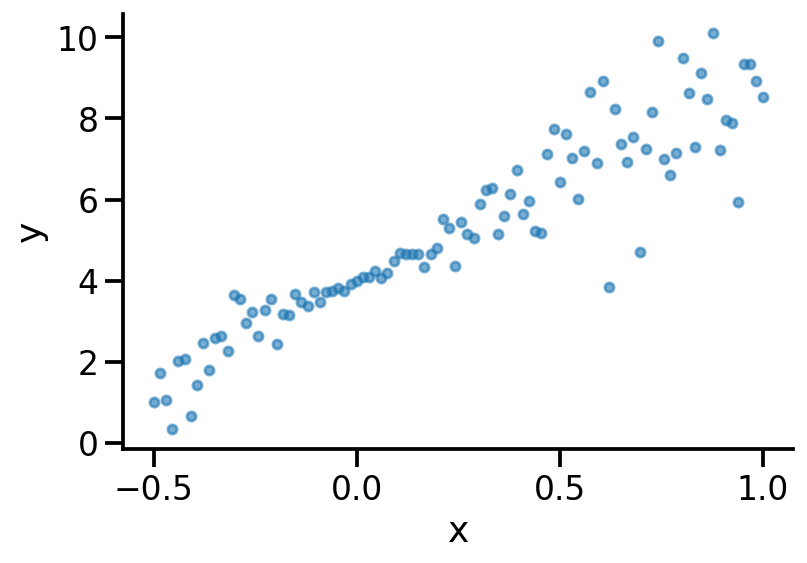

In [3]:
plt.scatter(x, y, s=20, alpha=0.6)
sns.despine()
plt.xlabel("x")
plt.ylabel("y")

#### Model 1: Vanilla Linear Regression

In [4]:
model = Sequential([
    Dense(input_shape=(1,), units=1, name='D1')])

2022-02-01 09:37:25.292936: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 D1 (Dense)                  (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [6]:
model.compile(loss='mse', optimizer='adam')
model.fit(x, y, epochs=4000, verbose=0)

In [7]:
model.get_layer('D1').weights

[<tf.Variable 'D1/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[4.929521]], dtype=float32)>,
 <tf.Variable 'D1/bias:0' shape=(1,) dtype=float32, numpy=array([3.997371], dtype=float32)>]

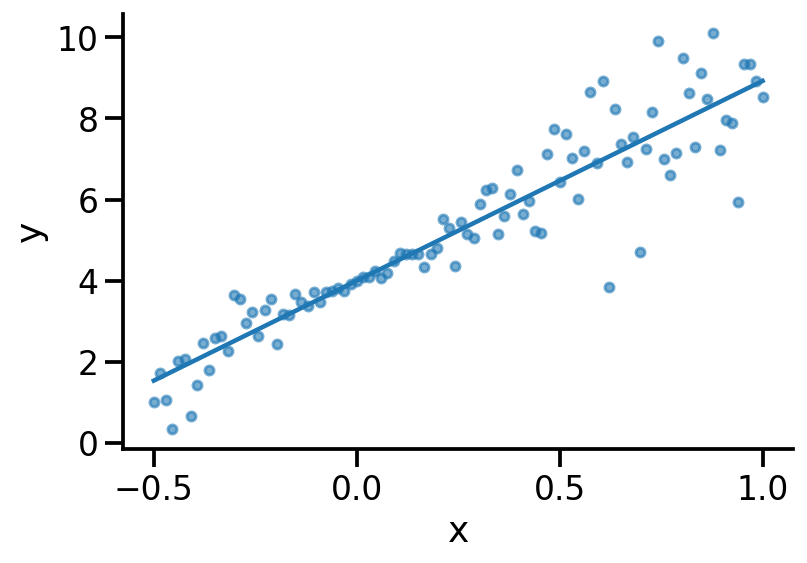

In [8]:
plt.scatter(x, y, s=20, alpha=0.6)
sns.despine()
plt.xlabel("x")
plt.ylabel("y")
pred_m1 = model.predict(x)
plt.plot(x, pred_m1)

#### Model 2

In [9]:
model_2 = Sequential([
    Dense(input_shape=(1,), units=1, name='M2_D1'),
    tfl.DistributionLambda(lambda loc: tfd.Normal(loc=loc, scale=1.), name='M2_Likelihood')])

2022-02-01 09:37:33.529583: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [10]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 M2_D1 (Dense)               (None, 1)                 2         
                                                                 
 M2_Likelihood (Distribution  ((None, 1),              0         
 Lambda)                      (None, 1))                         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [11]:
m2_untrained_weight = model_2.get_layer('M2_D1').weights

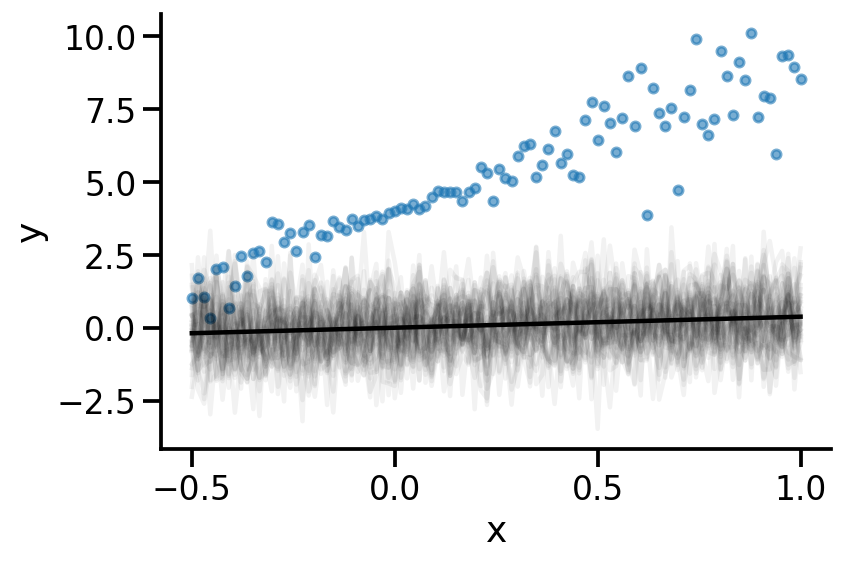

In [12]:
plt.scatter(x, y, s=20, alpha=0.6)
sns.despine()
plt.xlabel("x")
plt.ylabel("y")
m_2 = model_2(x)
plt.plot(x, m_2.sample(40).numpy()[:, :, 0].T, color='k', alpha=0.05);
plt.plot(x, m_2.mean().numpy().flatten(), color='k')

In [13]:
def plot(model):
    plt.scatter(x, y, s=20, alpha=0.6)
    sns.despine()
    plt.xlabel("x")
    plt.ylabel("y")
    m = model(x)
    m_s = m.stddev().numpy().flatten()
    m_m = m.mean().numpy().flatten()

    plt.plot(x, m_m , color='k')
    plt.fill_between(x, m_m-m_s, m_m+m_s, color='k', alpha=0.4)

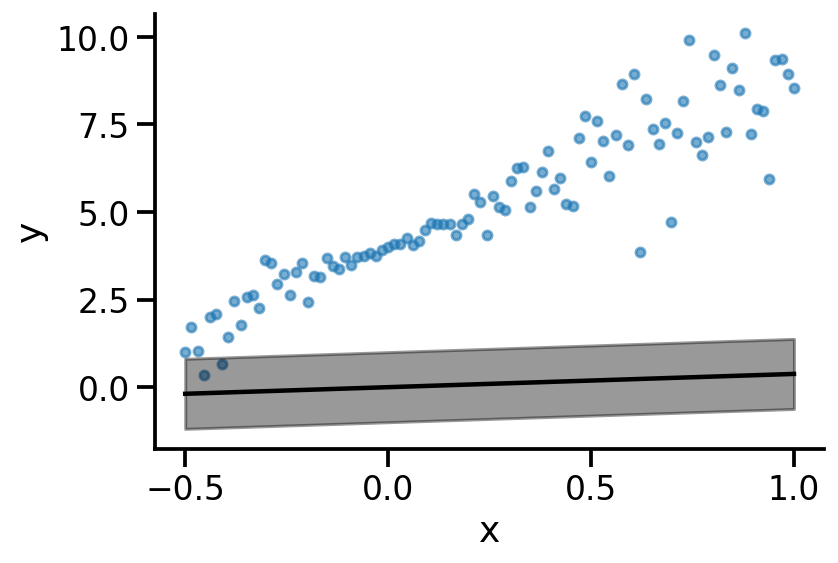

In [14]:
plot(model_2)

In [15]:
def nll(y_true, y_pred):
    # y_pred is distribution
    return -y_pred.log_prob(y_true)

In [16]:
model_2.compile(loss=nll, optimizer='adam')
model_2.fit(x, y, epochs=4000, verbose=0)

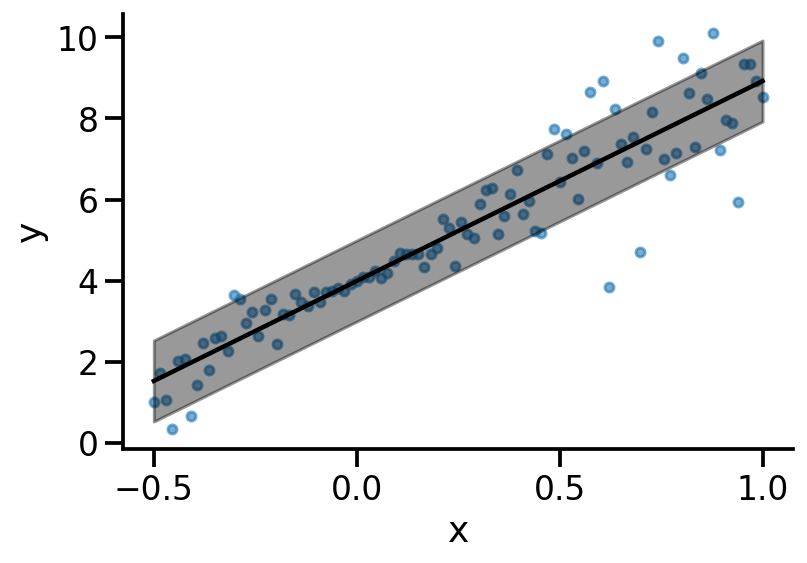

In [17]:
plot(model_2)

#### Model 3

In [18]:
model_3 = Sequential([
    Dense(input_shape=(1,), units=2, name='M3_D1'),
    tfl.DistributionLambda(lambda t: tfd.Normal(loc=t[..., 0], scale=tf.exp(t[..., 1])), name='M3_Likelihood')])

In [19]:
model_3.get_layer('M3_D1').weights

[<tf.Variable 'M3_D1/kernel:0' shape=(1, 2) dtype=float32, numpy=array([[0.04476571, 0.55212975]], dtype=float32)>,
 <tf.Variable 'M3_D1/bias:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=float32)>]

In [20]:
model_3.compile(loss=nll, optimizer='adam')
model_3.fit(x, y, epochs=4000, verbose=0)

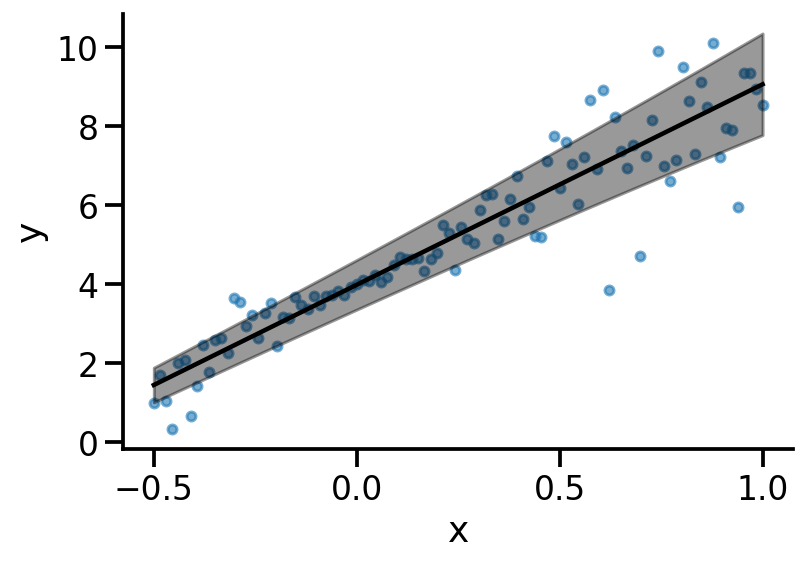

In [21]:
plot(model_3)

Good reference
https://tensorchiefs.github.io/bbs/files/21052019-bbs-Beate-uncertainty.pdf

At this point, we see that scale or sigma is a linear function of input x.

In [22]:
#### Model 4

In [23]:
model_4 = Sequential([
    Dense(input_shape=(1,), units=2, name='M4_D1', activation='relu'),
    Dense(units=2, name='M4_D2',  activation='relu'),
    Dense(units=2, name='M4_D3'),
    tfl.DistributionLambda(lambda t: tfd.Normal(loc=t[..., 0], scale=tf.math.softplus(t[..., 1])), name='M4_Likelihood')])

In [24]:
model_4.compile(loss=nll, optimizer='adam')
model_4.fit(x, y, epochs=4000, verbose=0)

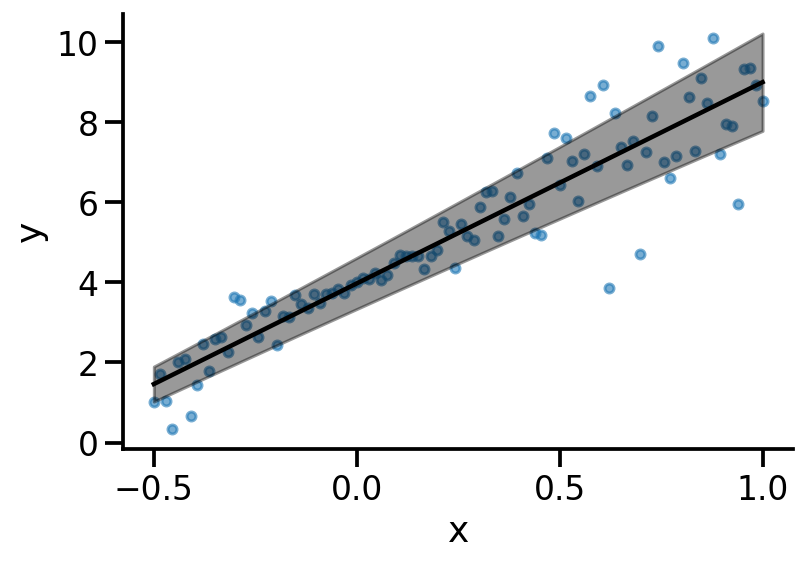

In [25]:
plot(model_4)

#### Model 5
Follow: https://juanitorduz.github.io/tfp_lm/

#### Model 6
Dense Variational

In [26]:
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    # Independent Normal Distribution
    return lambda t: tfd.Independent(tfd.Normal(loc=tf.zeros(n, dtype=dtype),
                                                scale=1),
                                     reinterpreted_batch_ndims=1)

def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    return Sequential([
        tfl.VariableLayer(tfl.IndependentNormal.params_size(n), dtype=dtype),
        tfl.IndependentNormal(n)
    ])

In [38]:
N = len(x)
model_6 = Sequential([
    # Requires posterior and prior distribution
    # Add kl_weight for weight regularization
    #tfl.DenseVariational(16, posterior, prior, kl_weight=1/N, activation='relu', input_shape=(1, )),
    tfl.DenseVariational(2, posterior, prior, kl_weight=1/N, input_shape=(1,)),
    tfl.IndependentNormal(1)
])

In [39]:
model_6.compile(loss=nll, optimizer='adam')



In [42]:
model_6.fit(x, y, epochs=5000, verbose=0)

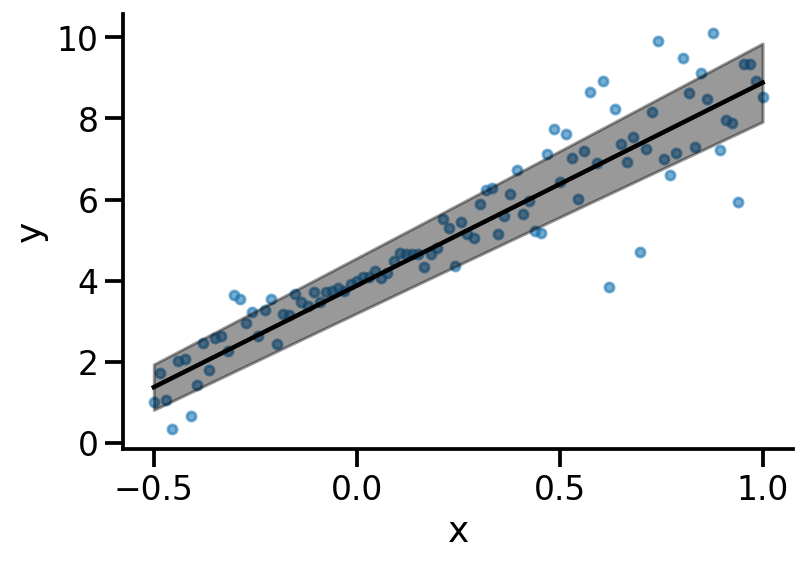

In [43]:
plot(model_6)

In [44]:
N = len(x)
model_7 = Sequential([
    # Requires posterior and prior distribution
    # Add kl_weight for weight regularization
    tfl.DenseVariational(16, posterior, prior, kl_weight=1/N, activation='relu', input_shape=(1, )),
    tfl.DenseVariational(2, posterior, prior, kl_weight=1/N),
    tfl.IndependentNormal(1)
])

model_7.compile(loss=nll, optimizer='adam')



In [49]:
model_7.fit(x, y, epochs=5000, verbose=0)

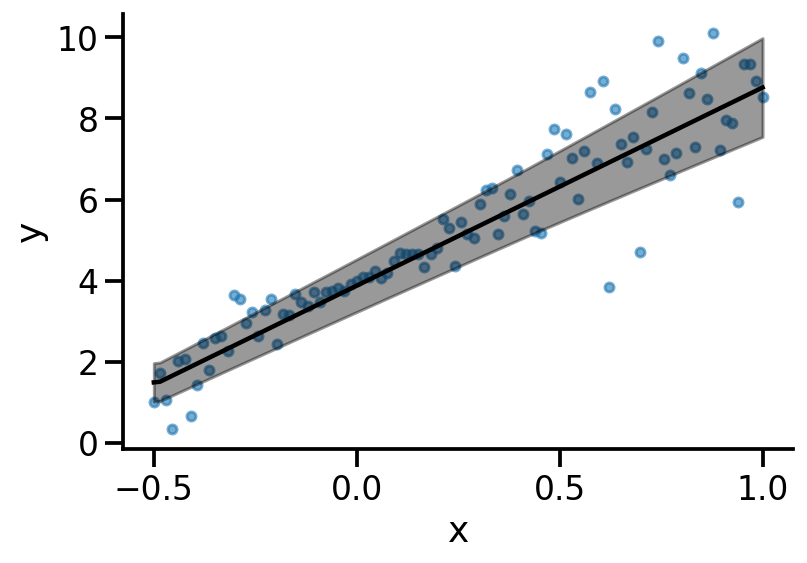

In [50]:
plot(model_7)

https://livebook.manning.com/book/probabilistic-deep-learning-with-python/chapter-8/123